<center>

---

# **Random Forest**

---
</center>


Un modelo **Random Forest** está formado por un conjunto (ensemble) de árboles de decisión individuales, cada uno entrenado con una muestra aleatoria extraída de los datos de entrenamiento originales mediante bootstrapping).

- Cada árbol se entrena con unos datos ligeramente distintos.
- En cada árbol individual, las observaciones se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal.
- La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.


##Ventajas

- Son capaces de seleccionar predictores de forma automática.

- Pueden aplicarse a problemas de regresión y clasificación.

- Los árboles pueden, en teoría, manejar tanto predictores numéricos como categóricos sin tener que crear variables dummy o one-hot-encoding. En la práctica, esto depende de la implementación del algoritmo que tenga cada librería.

- Al tratarse de métodos no paramétricos, no es necesario que se cumpla ningún tipo de distribución específica.

- Por lo general, requieren mucha menos limpieza y pre procesado de los datos en comparación a otros métodos de aprendizaje estadístico (por ejemplo, no requieren estandarización).

- No se ven muy influenciados por outliers.

- Si para alguna observación, el valor de un predictor no está disponible, a pesar de no poder llegar a ningún nodo terminal, se puede conseguir una predicción empleando todas las observaciones que pertenecen al último nodo alcanzado. La precisión de la predicción se verá reducida pero al menos podrá obtenerse.

- Son muy útiles en la exploración de datos, permiten identificar de forma rápida y eficiente las variables (predictores) más importantes.

- Gracias al Out-of-Bag Error puede estimarse su error de validación sin necesidad de recurrir a estrategias computacionalmente costosas como la validación cruzada. Esto no aplica en el caso de series temporales.

- Tienen buena escalabilidad, pueden aplicarse a conjuntos de datos con un elevado número de observaciones

##Desventajas

- Al combinar múltiples árboles, se pierde la interpretabilidad que tienen los modelos basados en un único árbol.

- Cuando tratan con predictores continuos, pierden parte de su información al categorizarlas en el momento de la división de los nodos.

- Tal y como se describe más adelante, la creación de las ramificaciones de los árboles se consigue mediante el algoritmo de recursive binary splitting. Este algoritmo identifica y evalúa las posibles divisiones de cada predictor acorde a una determinada medida (RSS, Gini, entropía…).

- Los predictores continuos o predictores cualitativos con muchos niveles tienen mayor probabilidad de contener, solo por azar, algún punto de corte óptimo, por lo que suelen verse favorecidos en la creación de los árboles.

- No son capaces de extrapolar fuera del rango de los predictores observado en los datos de entrenamiento.


## Predicción de Random Forest


La predicción de un modelo Random Forest es la media de las predicciones de todos los árboles que lo forman.

Supóngase que se dispone de 10 observaciones, cada una con un valor de variable respuesta  $Y$  y unos predictores  $X$ .


\begin{array}{rrrrrrrrrrr}
\hline \text { id } & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 & 10 \\
Y & 10 & 18 & 24 & 8 & 2 & 9 & 16 & 10 & 20 & 14 \\
X & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots
\end{array}

La siguiente imagen muestra cómo sería la predicción del modelo para una nueva observación.



 <img src="https://drive.google.com/uc?id=1ac6vwz2f58Zh7z6SUGUsUnLmMAxyZOK3" />

el valor predicho por cada árbol es la media de la variable respuesta  Y  en el nodo terminal. Acorde a la imagen, las predicciones de cada uno de los tres árboles (de izquierda a derecha) es:


$\hat{y}_{arbol_1} = \frac{24 + 2 + 20}{3} = 15.33333$

$\hat{y}_{arbol_2} = \frac{18 + 24}{2} = 21$

$\hat{y}_{arbol_3} = \frac{18 + 24 + 2 + 20}{4} = 16$

La predicción final del modelo es la media de todas las predicciones individuales:

$\hat{\mu} = \frac{15.33333+21+16}{3} = 17.4$




# Random Forest

In [1]:
!pip install scikit-learn==1.3.2

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
#from sklearn.datasets import load_boston
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
sns.set_theme()

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# Datos


El set de datos Boston disponible en la librería scikitlearn contiene precios de viviendas de la ciudad de Boston, así como información socio-económica del barrio en el que se encuentran.

**objetivo:** Ajustar un modelo de regresión que permita predecir el precio medio de una vivienda ```(MEDV)``` en función de las variables disponibles.

Número de instancias(observaciones): 506

Número de atributos: 13 predictivos numéricos/categoriales.



Información de atributos (variables):
- `CRIM`: índice de criminalidad per cápita por ciudad
- `ZN`: proporción de suelo residencial para lotes de más de 25.000 pies cuadrados
- `INDUS`: proporción de acres comerciales no minoristas por ciudad
- `CHAS`: variable ficticia del río Charles (= 1 si la zona linda con el río; 0 en caso contrario)
- `NOX`: concentración de óxidos nítricos (partes por 10 millones)
- `RM`: número medio de habitaciones por vivienda
- `AGE`: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
- `DIS`: distancias ponderadas a cinco centros de empleo de Boston
- `RAD`: índice de accesibilidad a las autopistas radiales
- `TAX`: tasa de impuesto sobre la propiedad por valor total de 10.000 $.
- `PTRATIO`: ratio alumnos-docente por ciudad
- `B`: 1000(Bk - 0,63)^2 donde Bk es la proporción de negros por ciudad
- `LSTAT`: % de estatus inferior de la población
- `MEDV`: Valor medio de las viviendas ocupadas por sus propietarios en miles de dólares
Valores de atributos que faltan: Ninguno


Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset. https://archive.ics.uci.edu/ml/machine-learnin

In [3]:
datos = fetch_openml(name="boston", as_frame=True)
datos=datos.frame
datos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fet

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  B        506 non-null    float64 
 12  LSTAT    506 non-null    float64 
 13  MEDV     506 non-null    float64 
dtypes: category(2), float64(12)
memory usage: 49.0 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
datos.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap

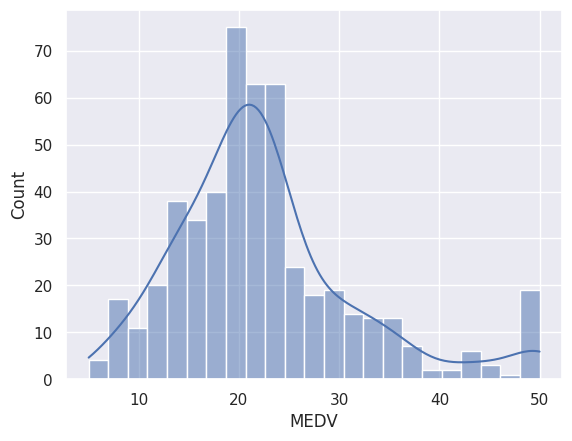

In [6]:
sns.histplot(datos["MEDV"], kde=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: ylabel='MEDV'>

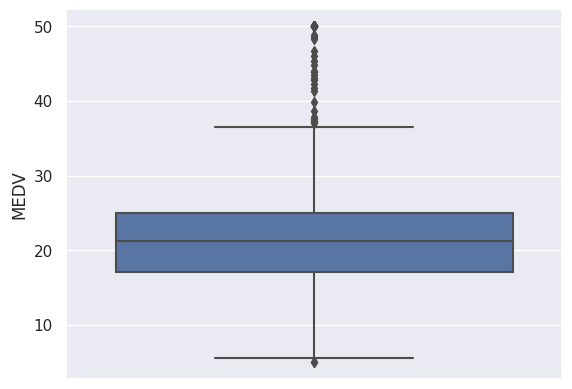

In [7]:
sns.boxplot(y=datos["MEDV"])

In [8]:
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


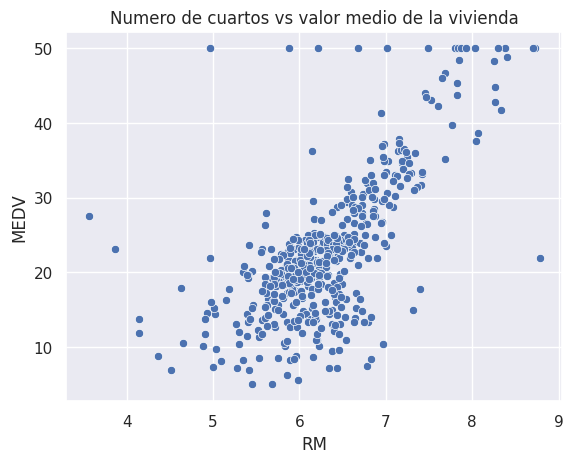

In [9]:
sns.scatterplot(data=datos, x="RM", y="MEDV")
plt.title("Numero de cuartos vs valor medio de la vivienda")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


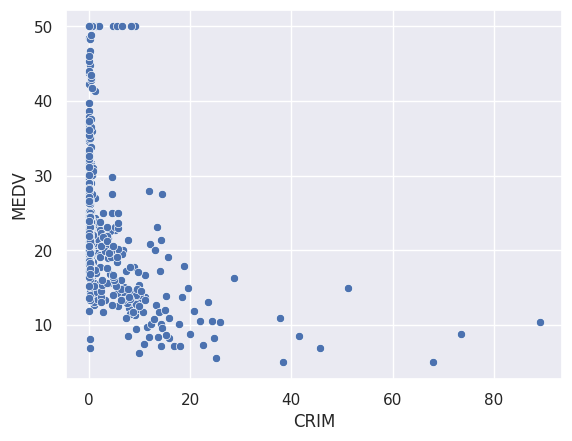

In [10]:
sns.scatterplot(data=datos, x="CRIM", y="MEDV")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


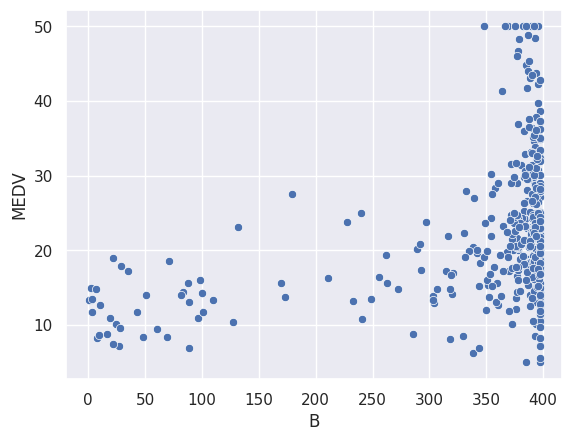

In [11]:
sns.scatterplot(x=datos["B"], y=datos["MEDV"])
plt.show()

In [12]:
!pip install sweetviz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
import sweetviz

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

In [14]:
reporte=sweetviz.analyze(datos, "MEDV")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                             |          | [  0%]   00:00 -> (? left)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



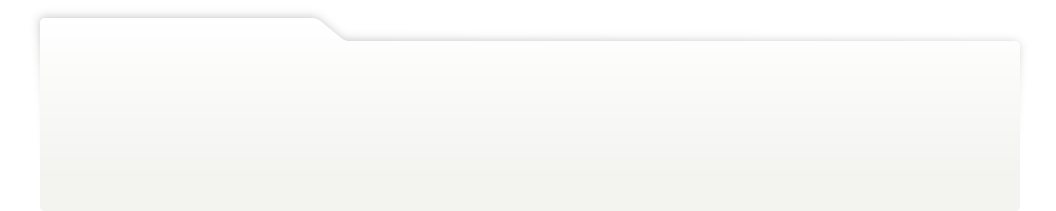
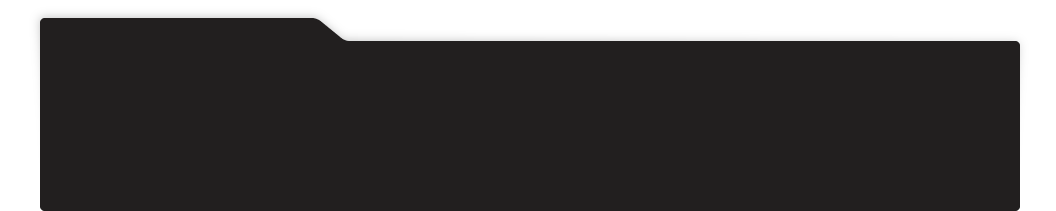
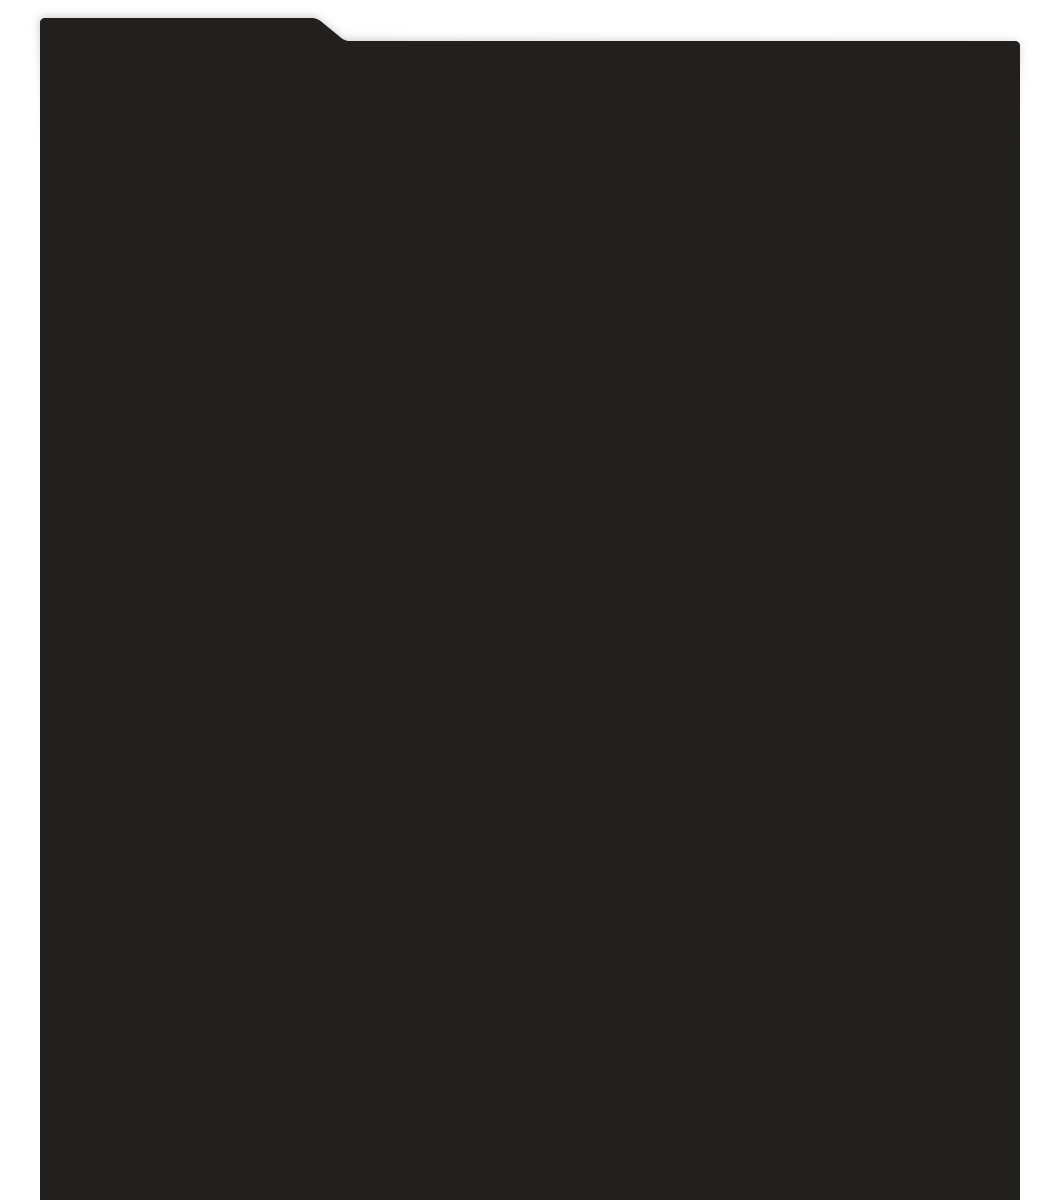
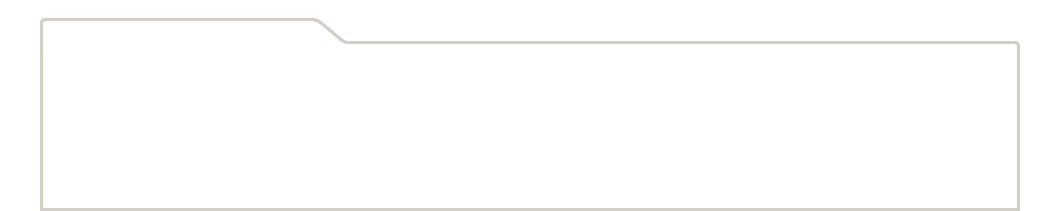
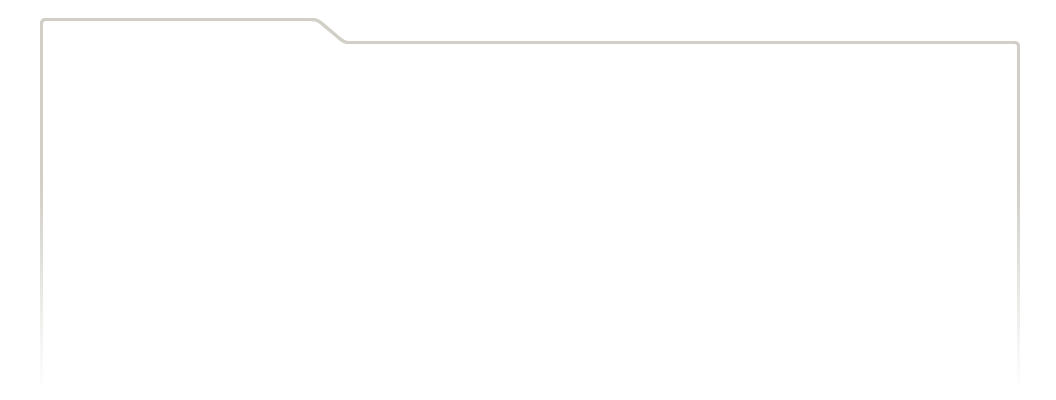
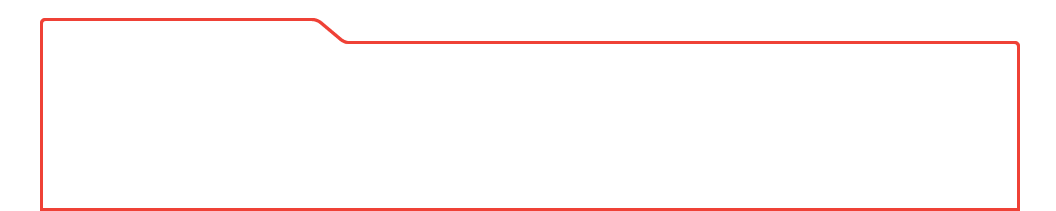
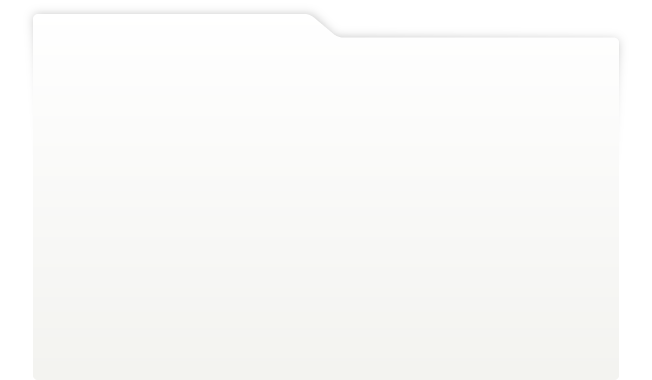
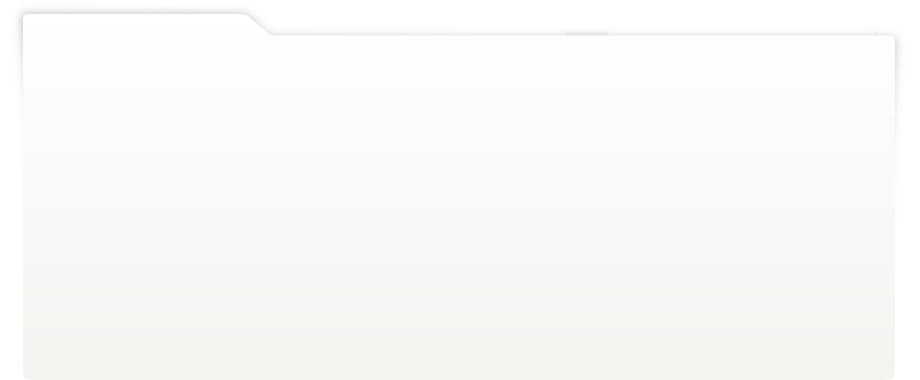
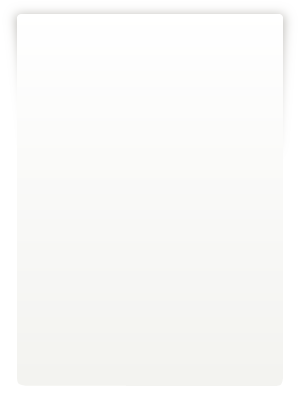
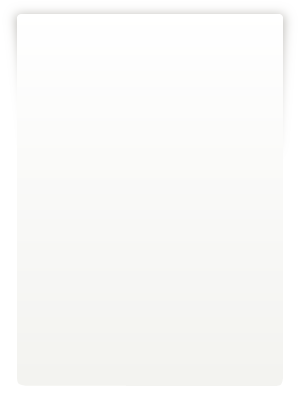
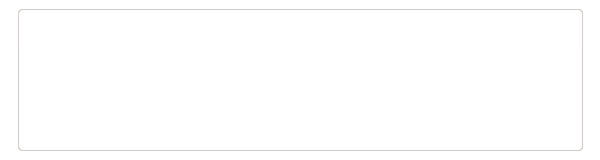
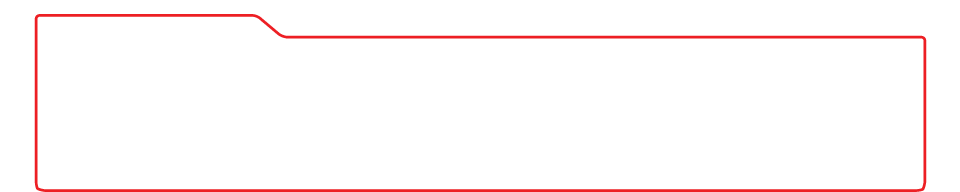
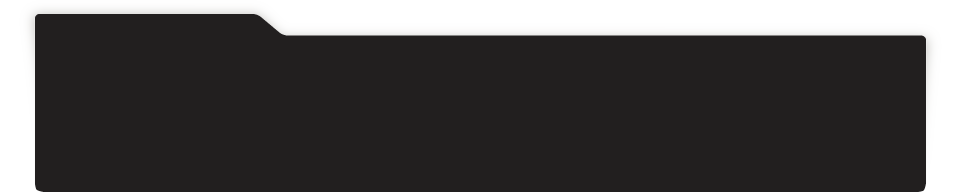
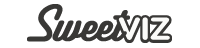
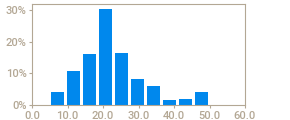
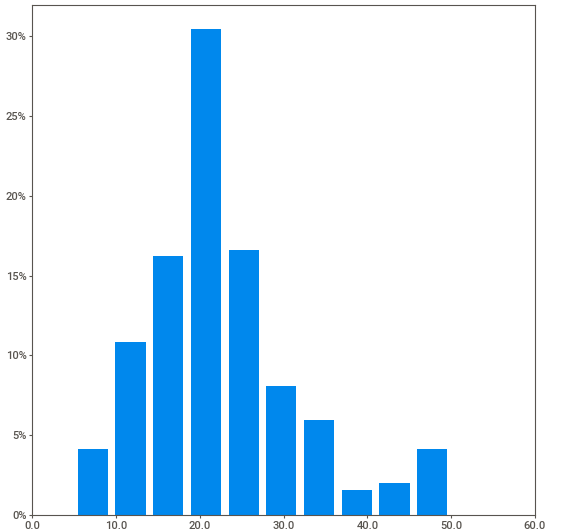
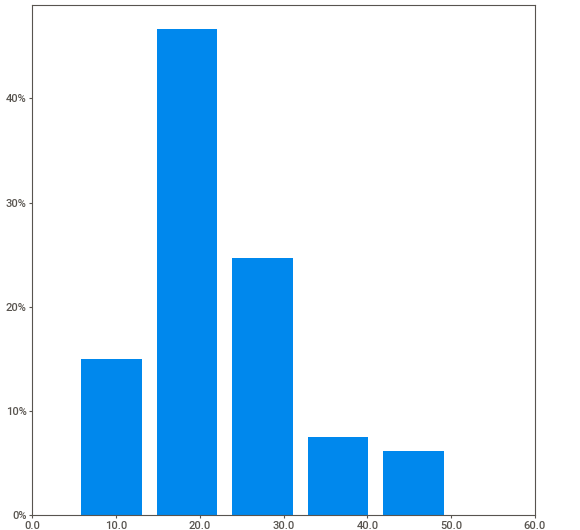
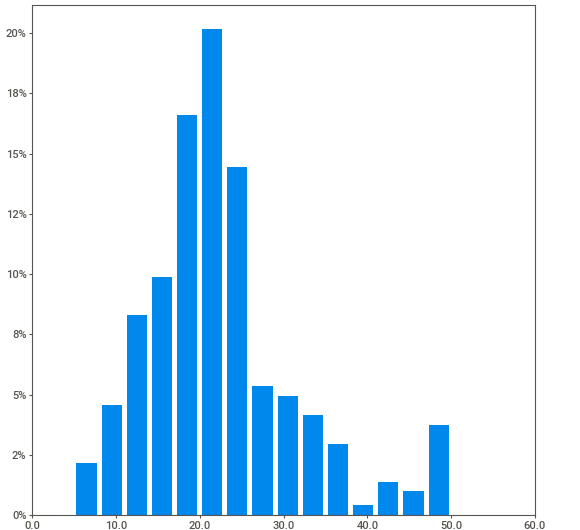
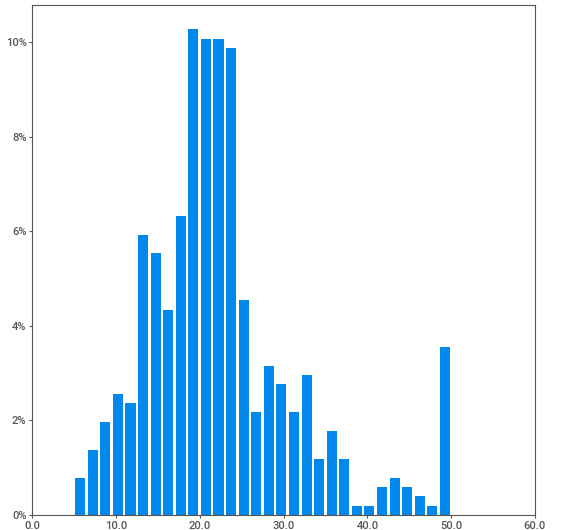
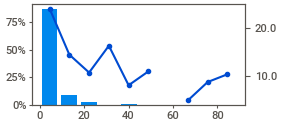
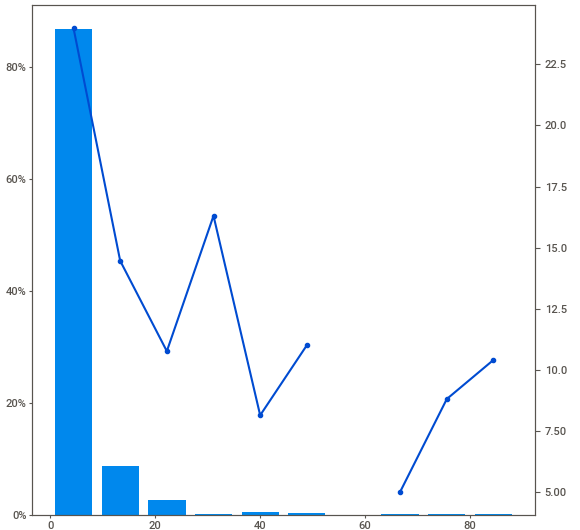
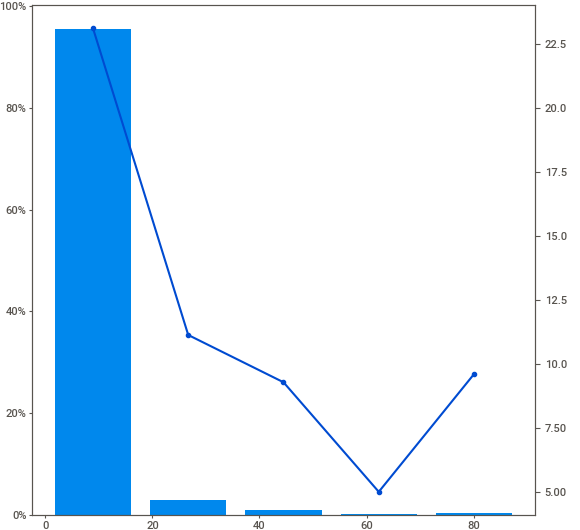
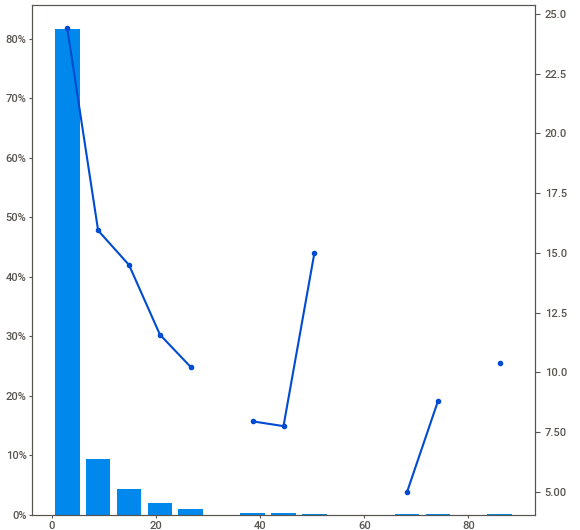
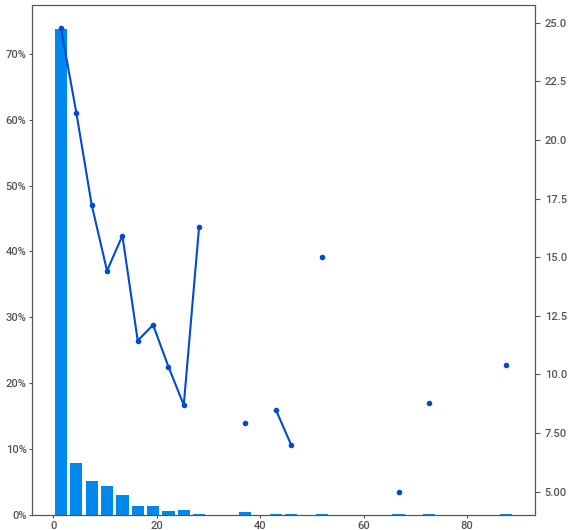
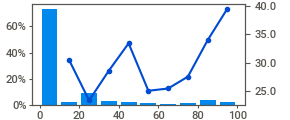
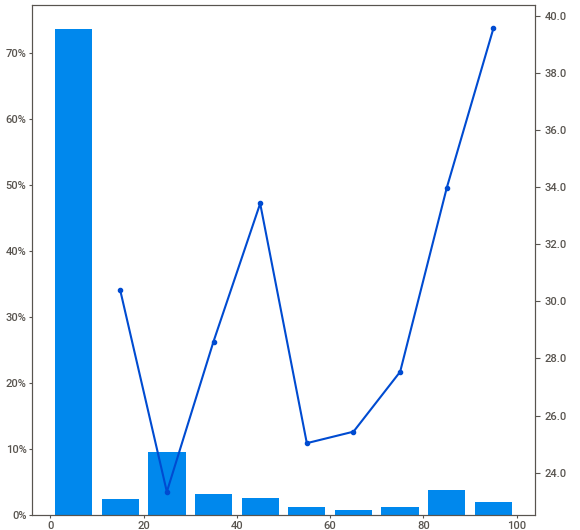
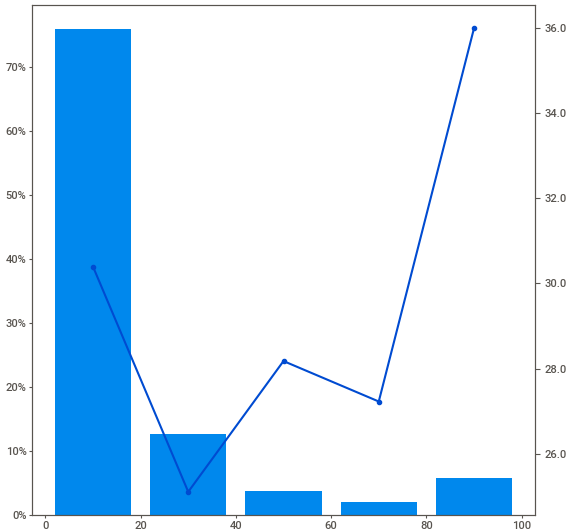
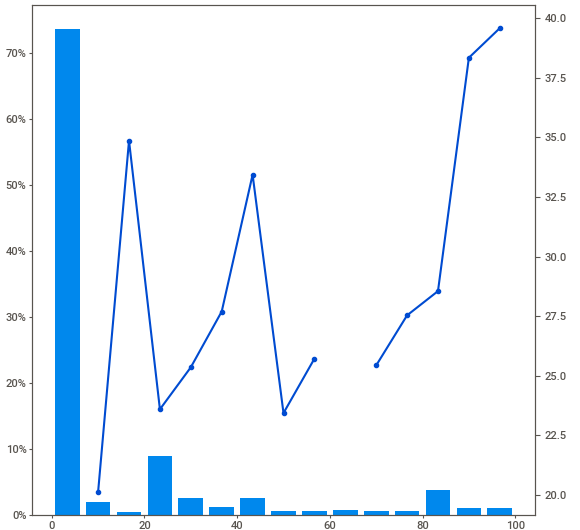
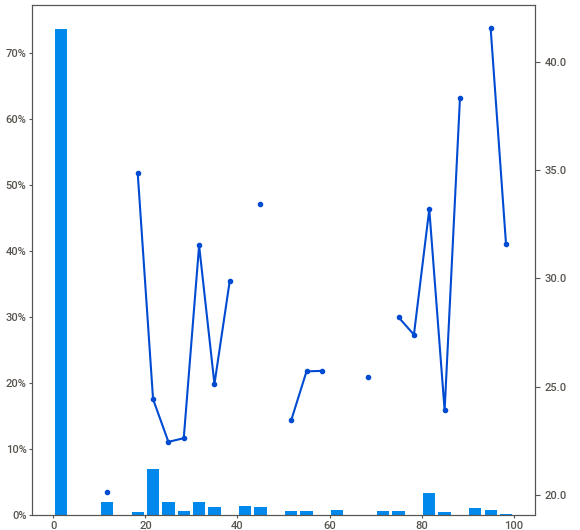
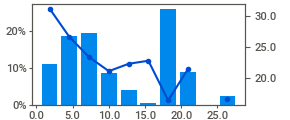
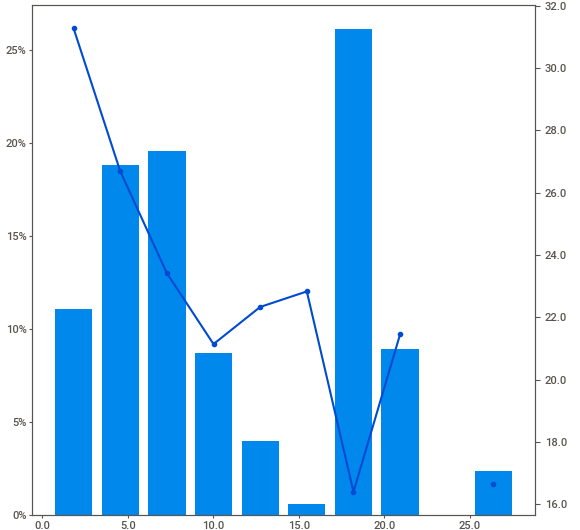
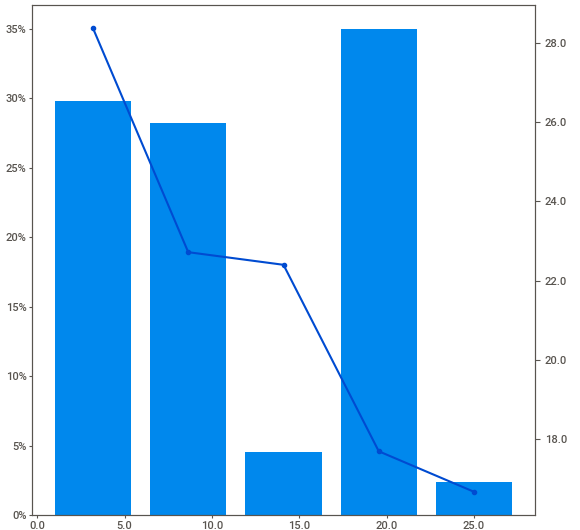
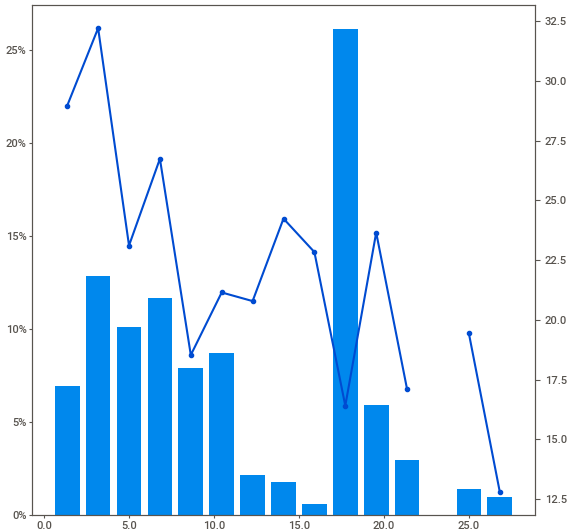
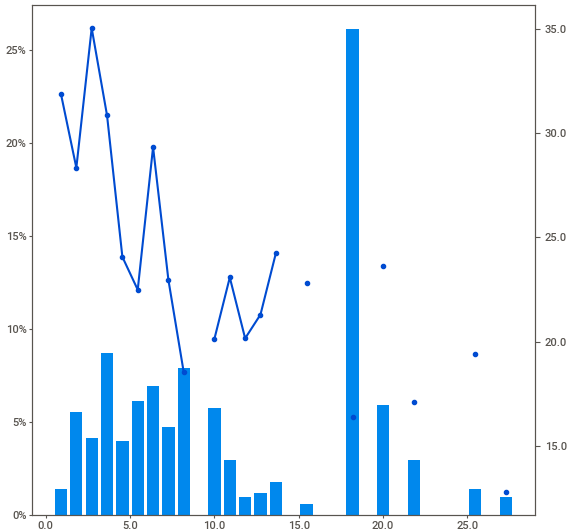
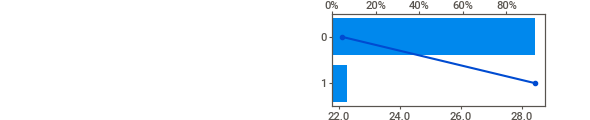
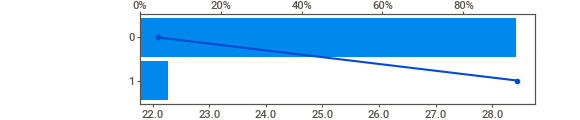
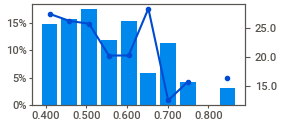
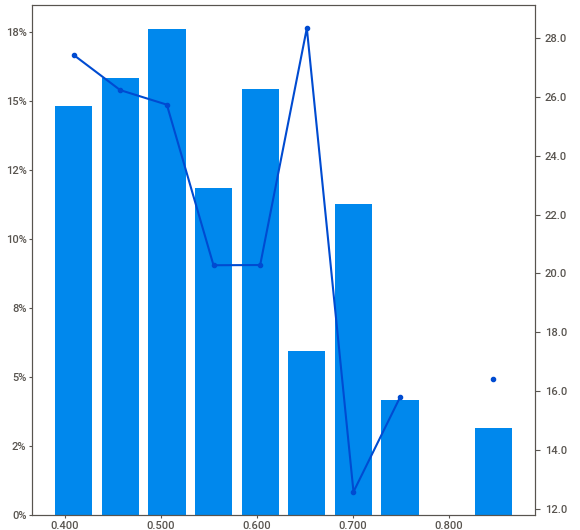
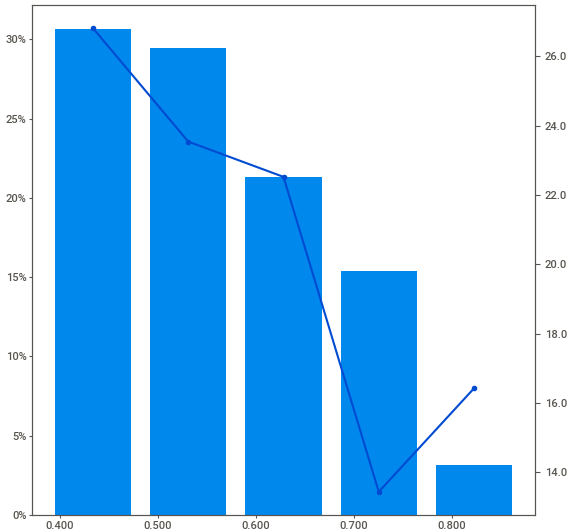
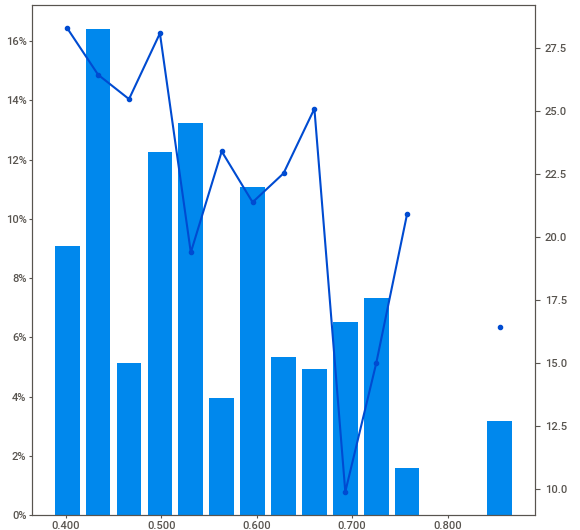
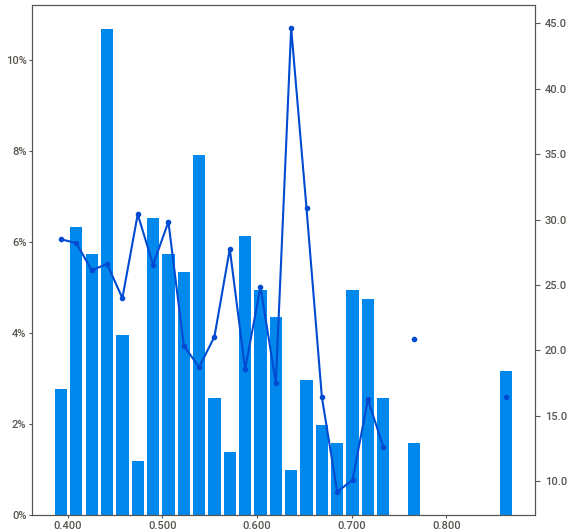
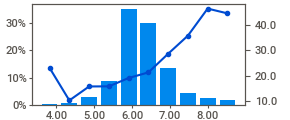
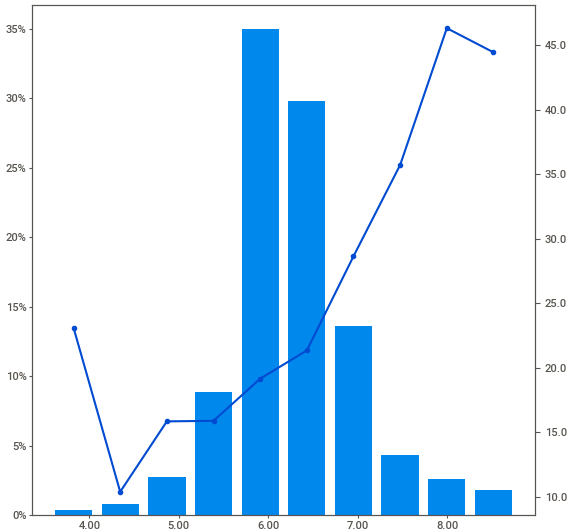
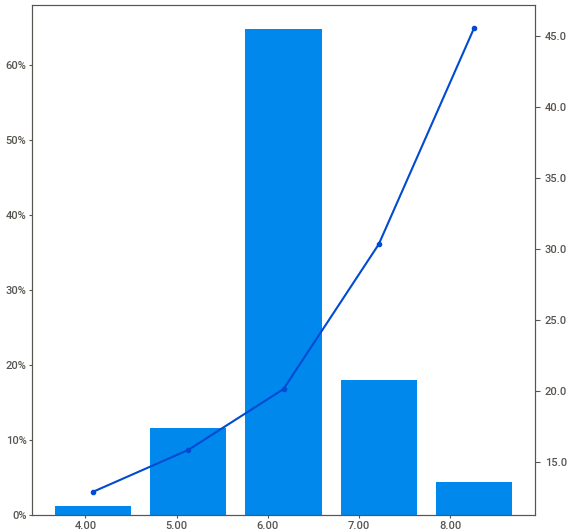
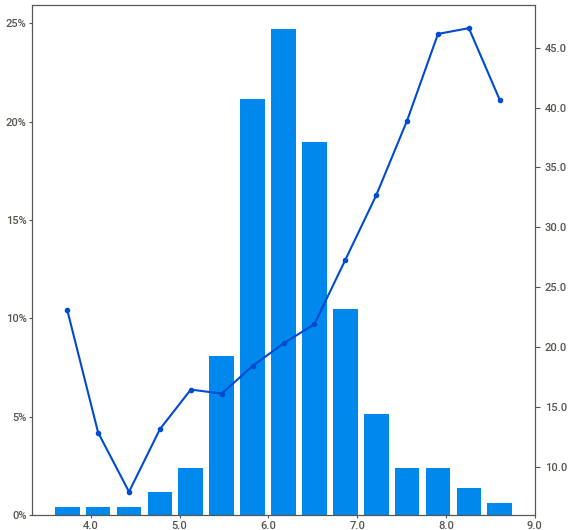
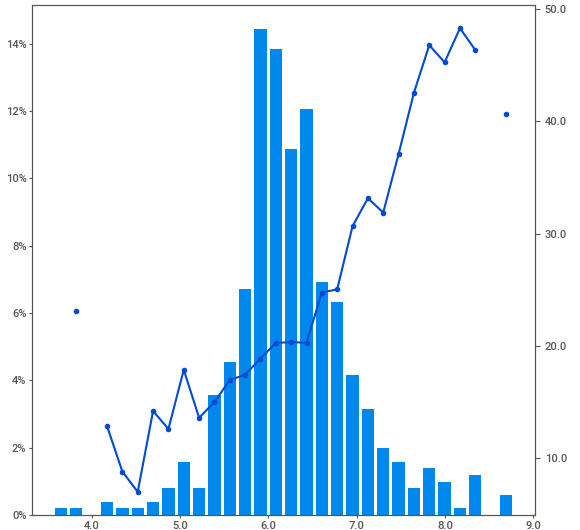
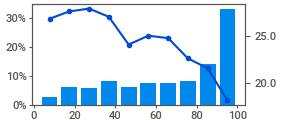
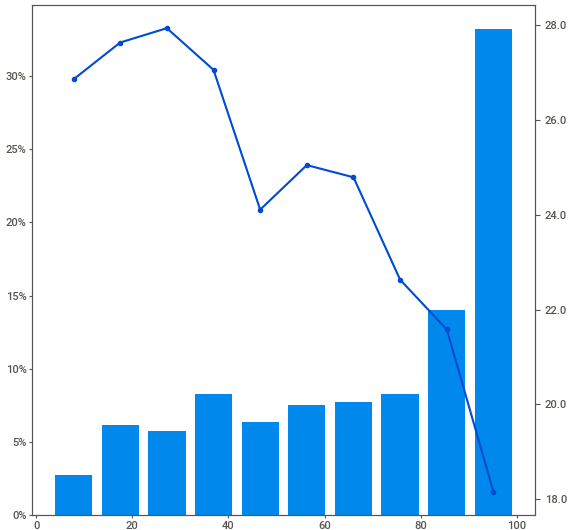
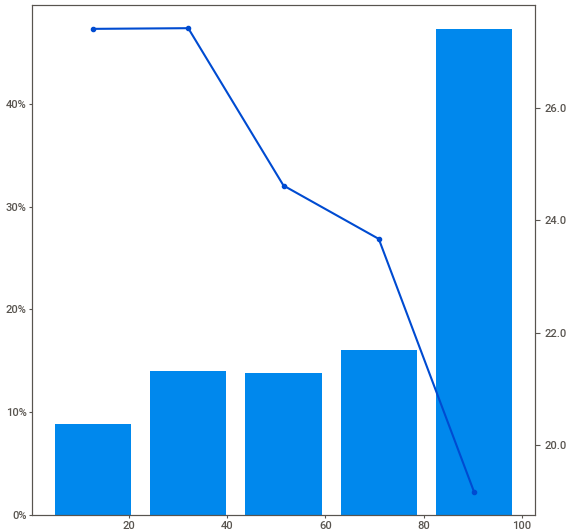
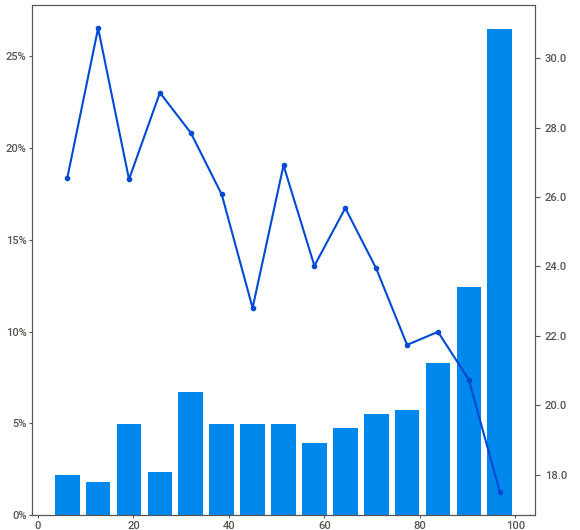
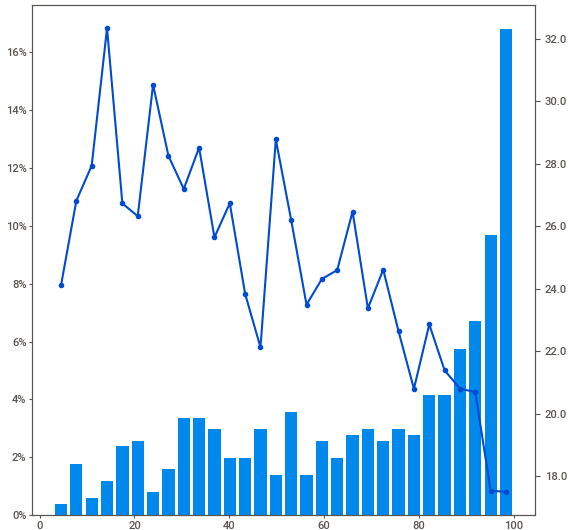
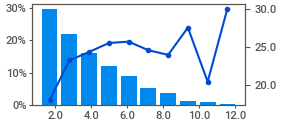
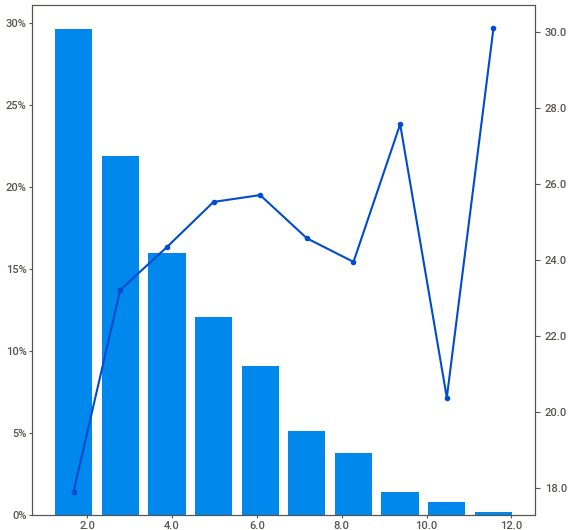
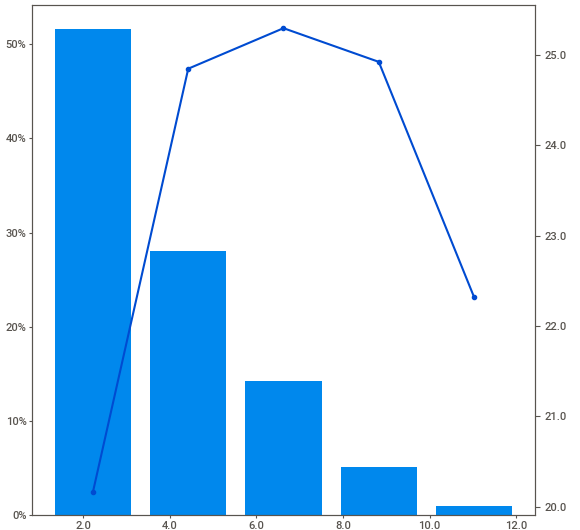
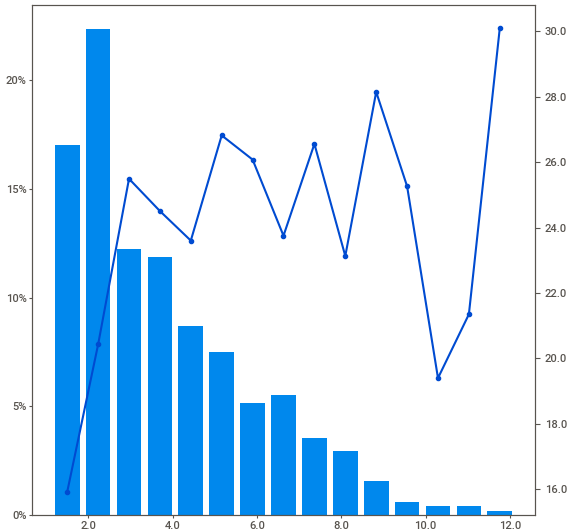
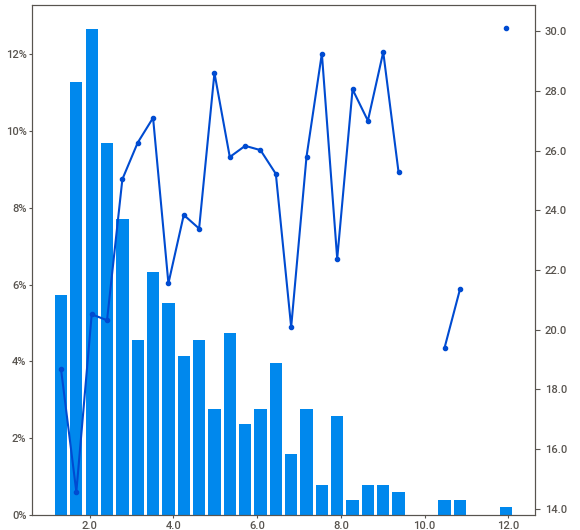
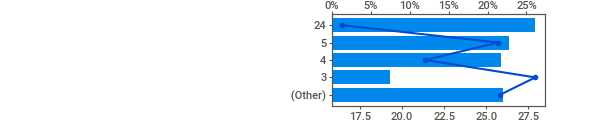
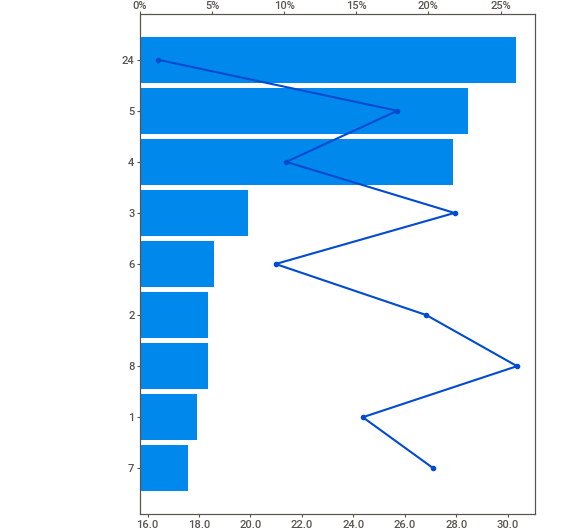
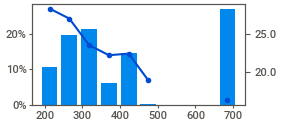
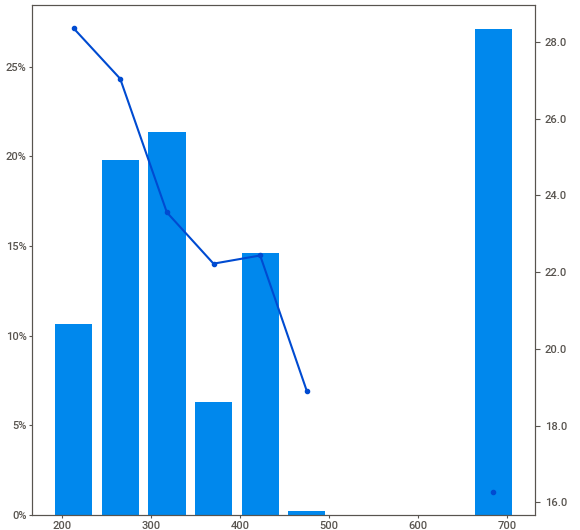
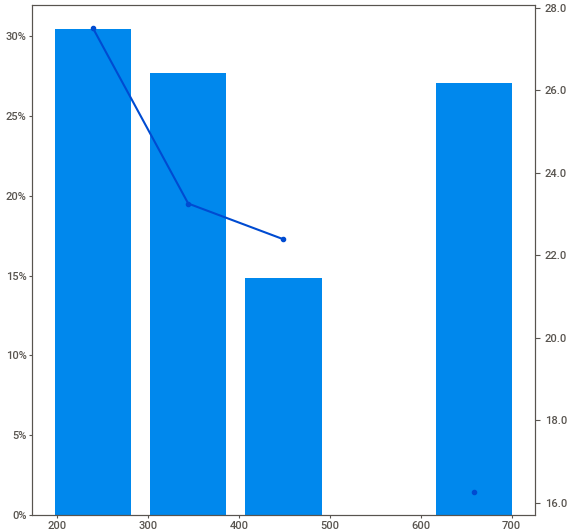
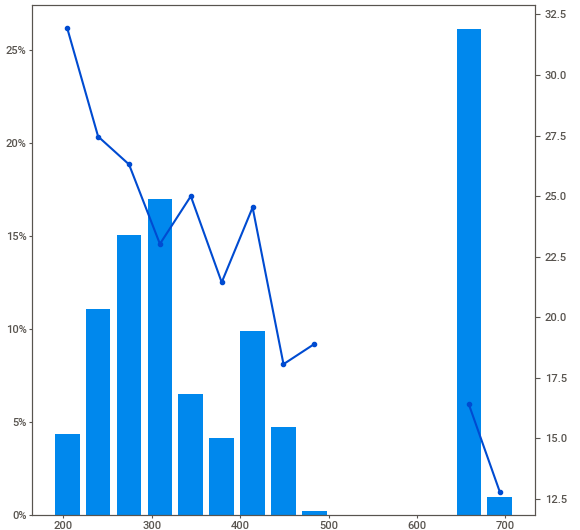
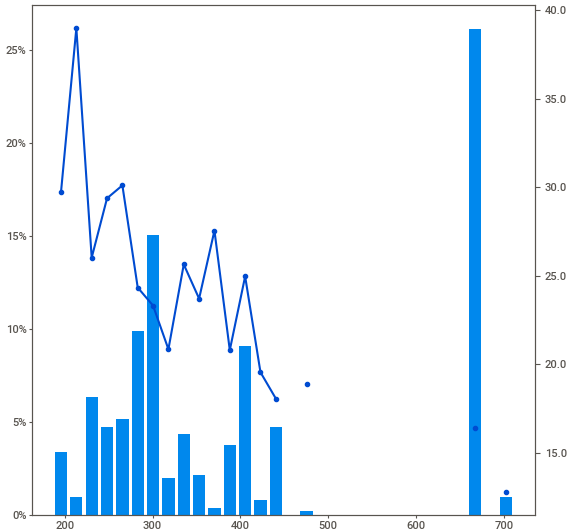
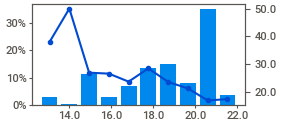
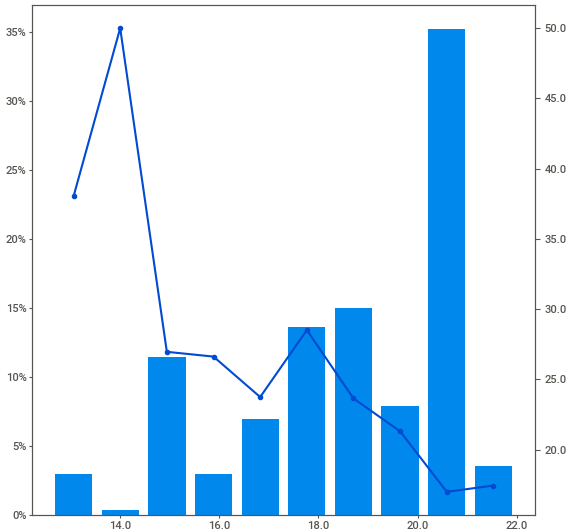
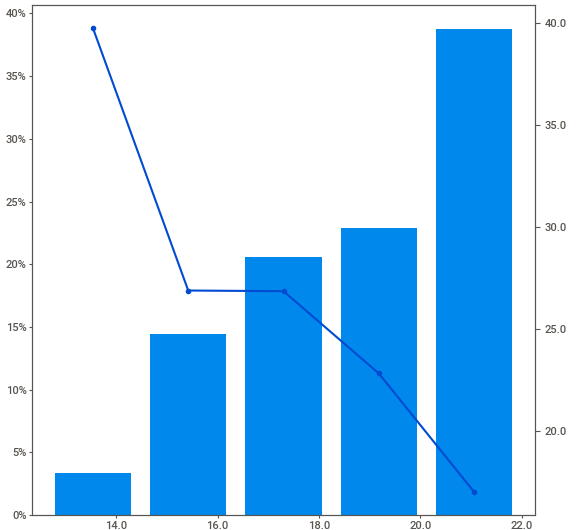
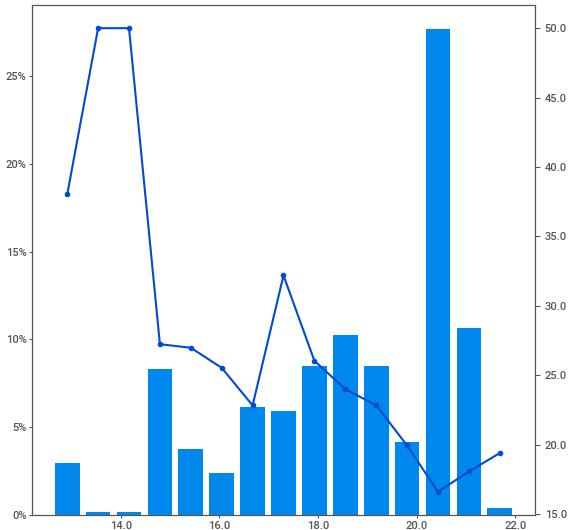
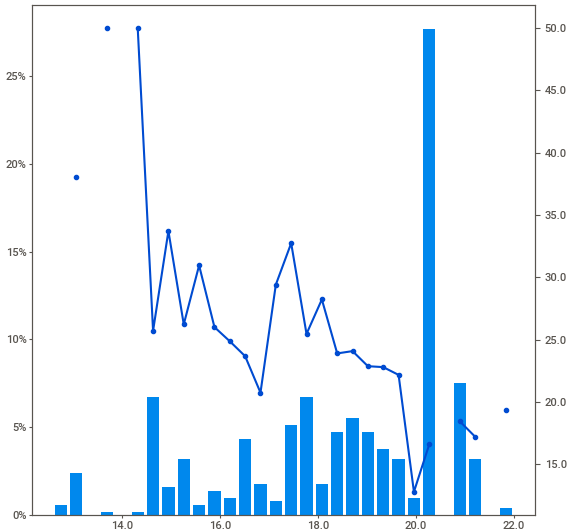
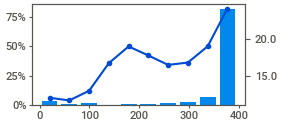
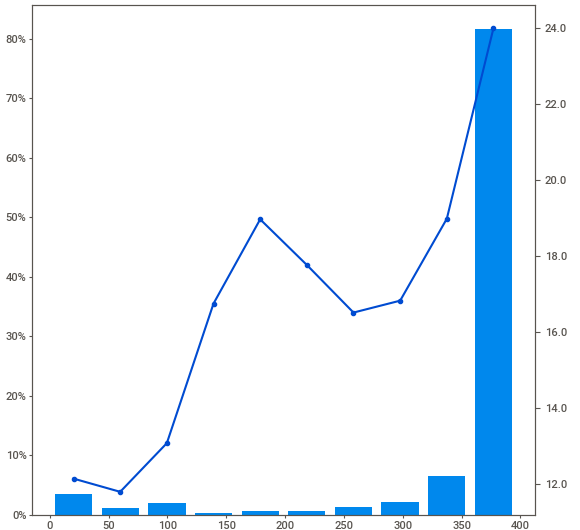
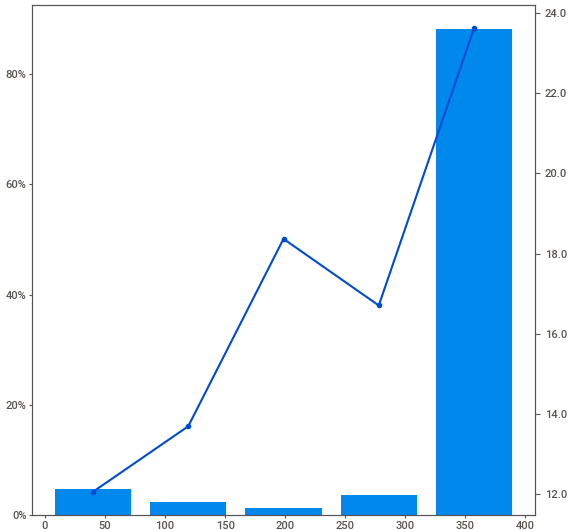
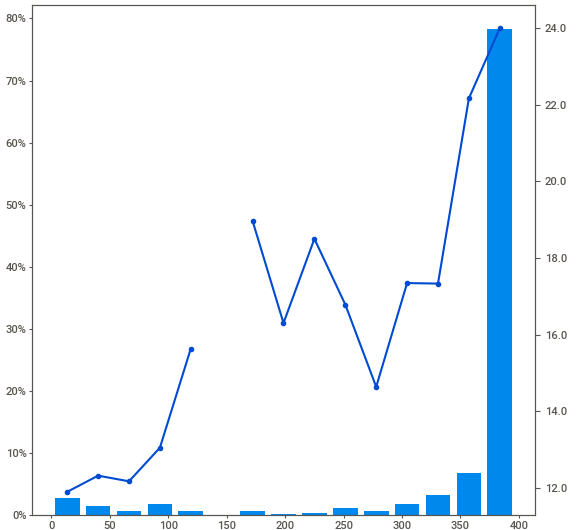
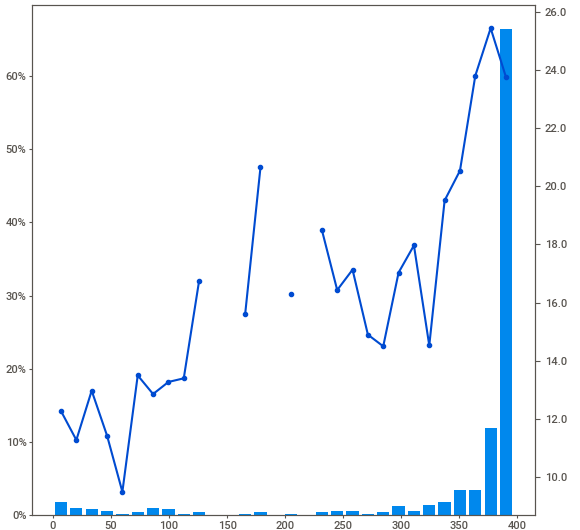
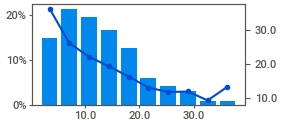
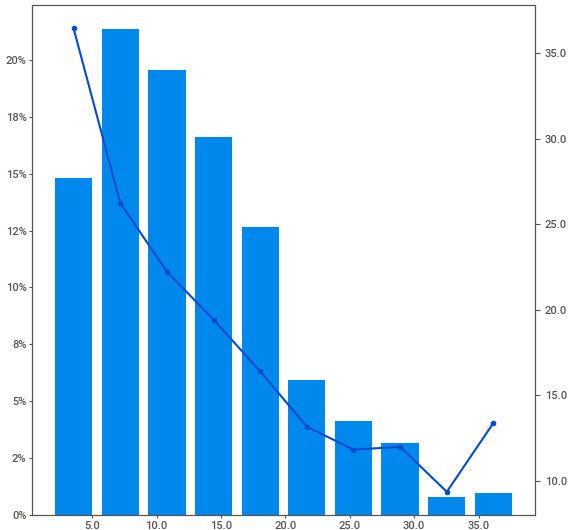
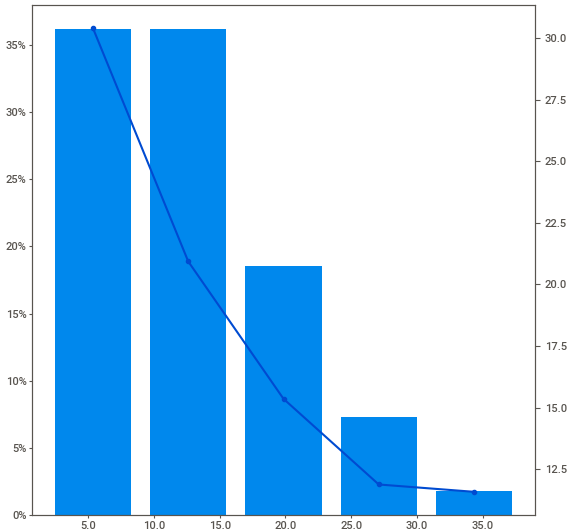
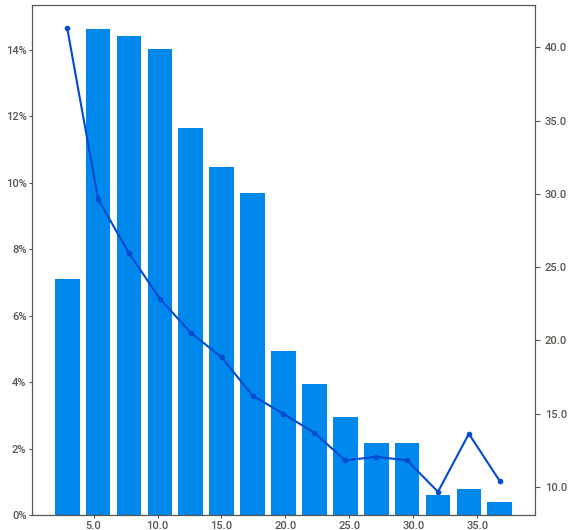
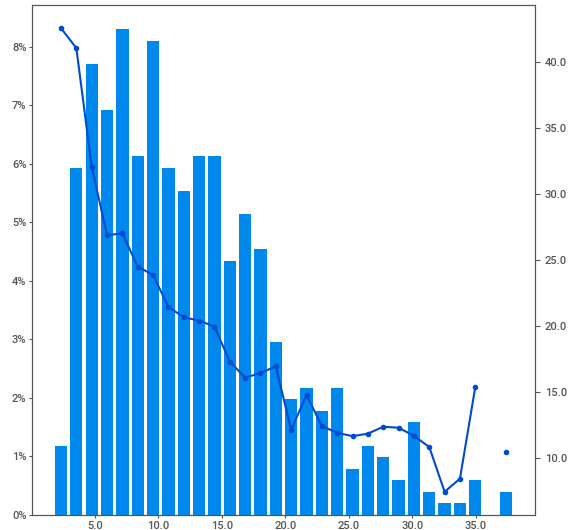
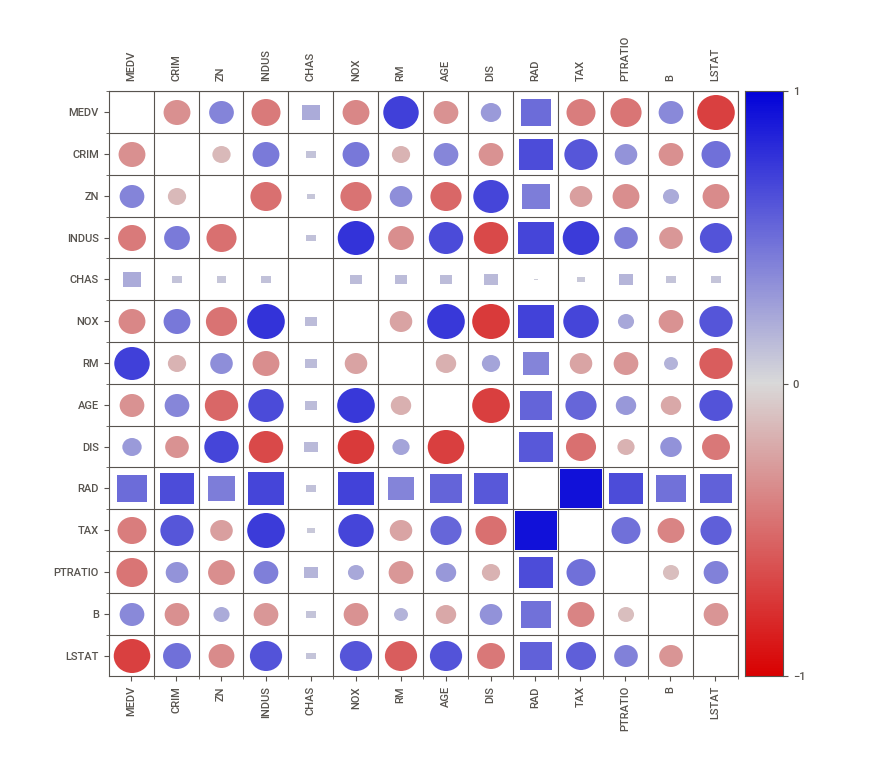
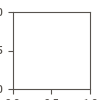

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [15]:
from IPython.display import HTML
reporte.show_html()
HTML('SWEETVIZ_REPORT.html')

<ipython-input-16-bc954ac9c5ff>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  c=datos.corr()


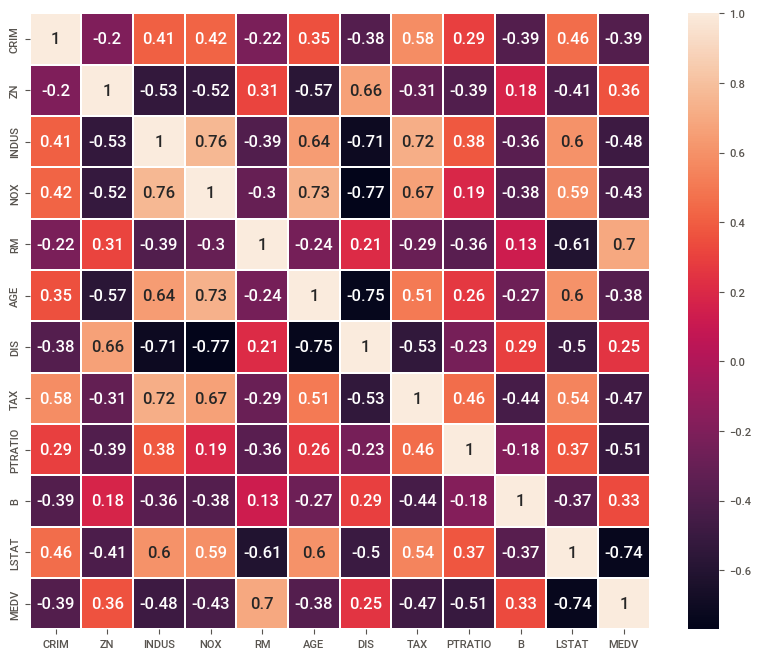

In [16]:
plt.figure(figsize = (10,8))
c=datos.corr()
sns.heatmap(c, annot=True, linewidths=.1)
plt.show()

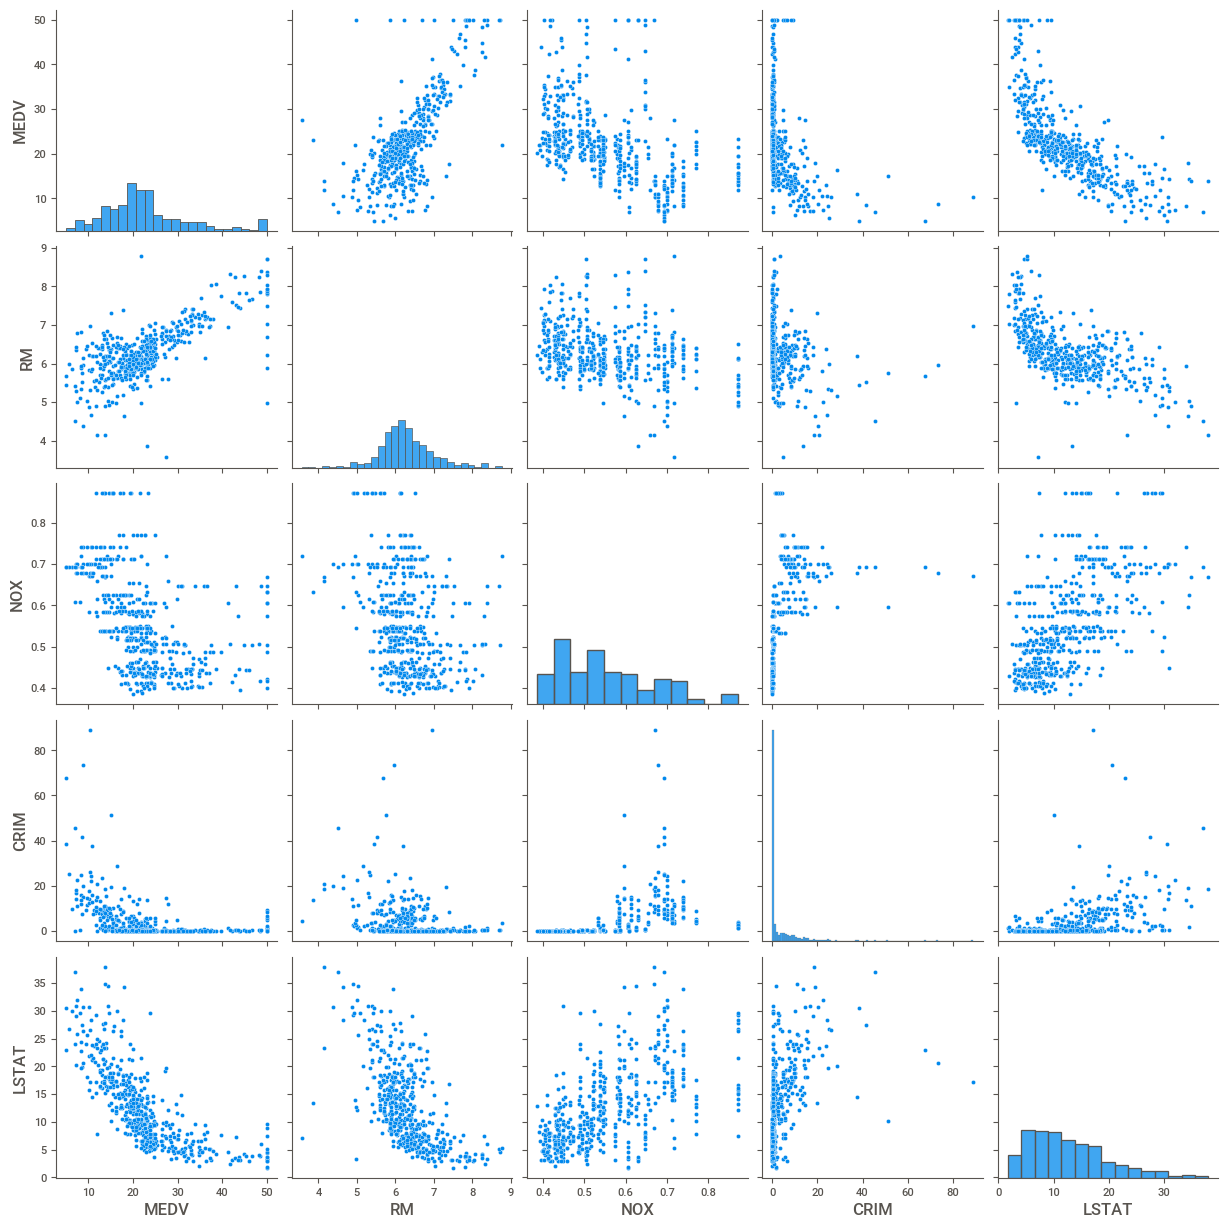

In [17]:
sns.pairplot(datos[["MEDV", "RM", "NOX", "CRIM", "LSTAT"]])
plt.show()

### Ajuste del modelo

Se ajusta un modelo empleando como variable respuesta `MEDV` y como predictores todas las otras variables disponibles.

La clase `RandomForestRegressor` del módulo sklearn.ensemble permite entrenar modelos random forest para problemas de regresión. Los parámetros e hiperparámetros empleados por defecto son:

- `n_estimators=100`
- `criterion='mse'`
- `max_depth=None`
- `min_samples_split=2`
- `min_samples_leaf=1`
- `min_weight_fraction_leaf=0.0`
- `max_features='auto'`
- `max_leaf_nodes=None`
- `min_impurity_decrease=0.0`
- `min_impurity_split=None`
- `bootstrap=True`
- `oob_score=False`
- `n_jobs=None`
- `random_state=None`
- `verbose=0`
- `warm_start=False`
- `ccp_alpha=0.0`
- `max_samples=None`

De entre todos ellos, destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

- `n_estimators`: número de árboles incluidos en el modelo.

- `max_depth`: profundidad máxima que pueden alcanzar los árboles.

- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

- `max_leaf_nodes`: número máximo de nodos terminales que pueden tener los árboles.

- `max_features`: número de predictores considerados a en cada división. Puede ser:

    + Un valor entero
    + Una fracción del total de predictores.
    + “auto”, utiliza todos los predictores.
    + “sqrt”, raiz cuadrada del número total de predictores.
    + “log2”, log2 del número total de predictores.
    + None, utiliza todos los predictores.
    + oob_score: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

- `n_jobs`: número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

- `random_state: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.


Como en todo estudio predictivo, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer esta evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.

### División de los datos en train y test

In [18]:
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = 123
                                    )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
print(X_train.shape)
print(X_test.shape)

(379, 13)
(127, 13)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creación del modelo

In [20]:
# ==============================================================================
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = "squared_error",
            max_depth    = None,
            max_features = None,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )



modelo de regresión de bosque aleatorio que utiliza 10 árboles sin limitación en la profundidad ni en el número de características consideradas por árbol. Este modelo puede ejecutarse en paralelo usando todos los núcleos de procesador disponibles y tiene una semilla aleatoria fija para la reproducibilidad. No se usa la evaluación OOB.


### Entrenamiento del modelo

In [21]:
# ==============================================================================
modelo.fit(X_train, y_train)

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

RandomForestRegressor(max_features=None, n_estimators=10, n_jobs=-1,
                      random_state=123)

### Predicción y evaluación del modelo


Una vez entrenado el modelo, se evalúa la capacidad predictiva empleando el conjunto de test

In [22]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 4.358493834335092


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
predicciones

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([30.58, 25.85, 48.46, 21.52, 29.62, 43.84, 23.04,  8.78, 17.71,
       30.43, 23.87, 20.61, 13.72, 24.39, 17.8 , 22.3 , 20.27, 48.29,
       18.53, 14.2 , 15.6 , 41.32, 31.28, 47.75, 40.61, 20.89, 15.33,
       20.12, 20.61, 20.48, 25.33, 35.12, 11.51, 21.19, 21.73, 32.72,
       24.79, 14.16, 14.72, 46.72, 31.02, 17.31, 38.3 , 50.  , 16.92,
       22.16, 18.6 , 20.48, 16.76, 39.09, 31.12, 28.78, 18.52, 10.31,
       22.06, 13.21, 12.69, 10.02, 31.97, 11.41, 18.69, 17.9 , 17.6 ,
       20.26, 20.76, 22.58, 22.98, 22.29, 22.81, 30.73, 19.81, 22.26,
       16.89, 25.25, 14.78, 16.37, 12.07, 19.7 , 30.52, 13.29, 32.02,
       10.92, 23.37, 21.59, 18.21, 21.85, 15.14, 20.15, 20.63, 30.12,
       11.79, 32.6 , 17.53, 23.96, 32.73, 31.05, 15.13, 32.12, 23.02,
       32.3 , 21.03, 13.12, 50.  , 12.42, 20.8 , 27.79, 20.08, 12.65,
       20.87, 26.  , 20.85, 19.71, 15.17, 19.55, 18.03, 25.97, 29.49,
       14.62, 20.87, 18.85, 21.4 , 35.26, 22.6 ,  9.97, 14.91, 23.78,
       20.95])

In [24]:
a=y_test.reset_index()

In [25]:
a.columns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['index', 'MEDV'], dtype='object')

Text(0.5, 0, ' Observaciones')

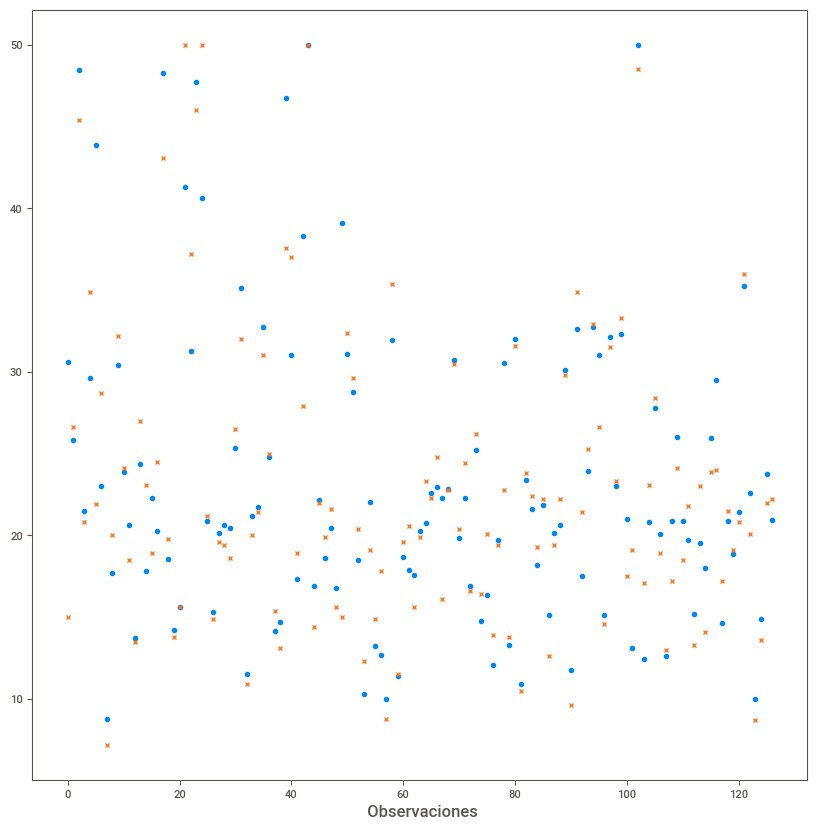

In [26]:
plt.figure(figsize=(10,10))
plt.plot(predicciones, "o")
plt.plot(a["MEDV"], "x")
plt.xlabel(" Observaciones")

<Axes: xlabel='MEDV'>

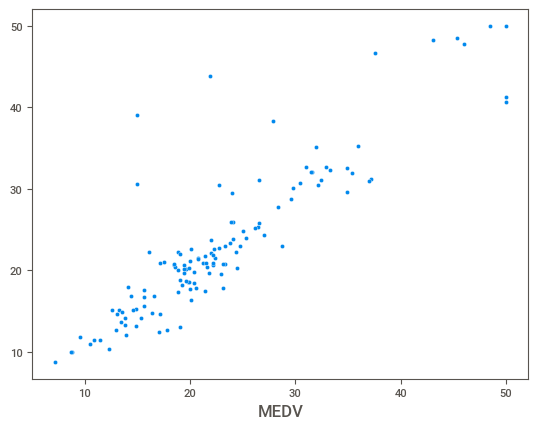

In [27]:
sns.scatterplot(x=a["MEDV"], y=predicciones )

## Optimización de hiperparámetros


- El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto.

- Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

- Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa.

En la implementación de `RandomForestRegressor`, la métrica devuelta como `oob_score` es el  R2 , si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

## Número de árboles


En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Valor óptimo de n_estimators: 111


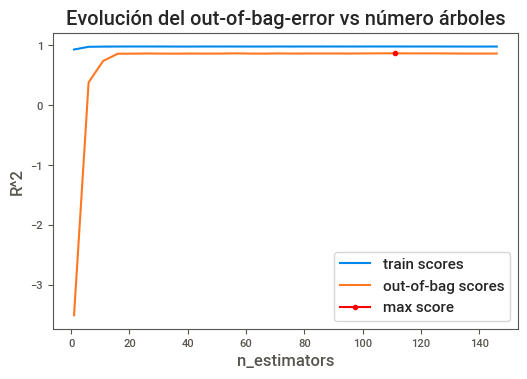

In [28]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'friedman_mse',
                max_depth    = None,
                max_features = None,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

In [29]:
import numpy as np

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Valor óptimo de n_estimators: 26


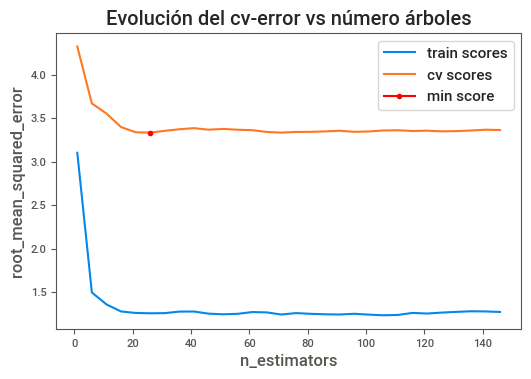

In [30]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
  modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = None,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
  modelo.fit(X_train, y_train)
  predicciones = modelo.predict(X = X_train)
  rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
  train_scores.append(rmse)

    # Error de validación cruzada
  scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
  cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

mbas métricas indican que, a partir de entre 20 y 60 árboles, el error de validación del modelo se estabiliza.

## Max features

El valor de `máx_features` es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Valor óptimo de max_features: 5


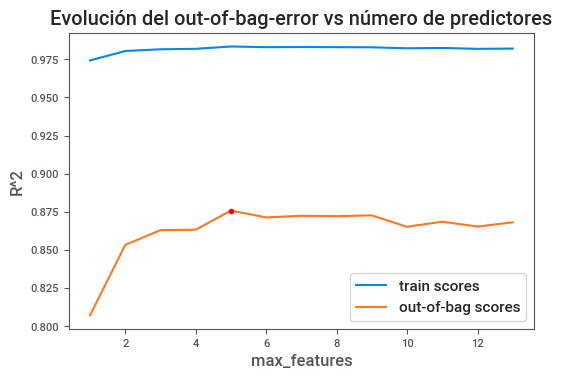

In [31]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Valor óptimo de max_features: 9


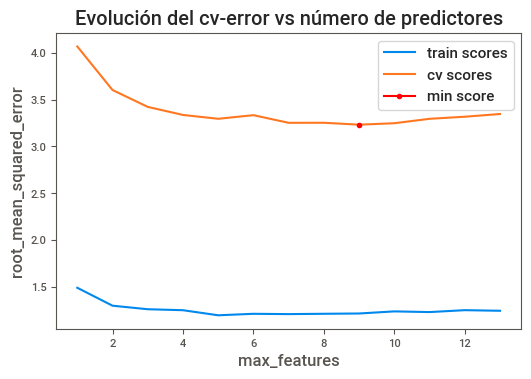

In [32]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:

    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Acorde a las dos métricas utilizadas, el valor óptimo de max_features está entre 5 y 9.

## Grid search


Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros. Puede encontrarse más información sobre las estrategias de búsqueda en Machine learning con Python y Scikit-learn.

### Grid Search basado en out-of-bag error

In [33]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100,150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train, y_train)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 100} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 100} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 100} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 

,oob_r2,max_depth,max_features,n_estimators
19,0.876112,20.0,5.0,150.0
1,0.876026,NaN,5.0,150.0
18,0.875975,20.0,5.0,100.0
0,0.875842,NaN,5.0,100.0


In [34]:
# VERSIÓN PARALELIZADA
# ==============================================================================

# Grid de hiperparámetros evaluados
# ==============================================================================
#param_grid = ParameterGrid(
#                {'n_estimators': [150],
#                 'max_features': [5, 7, 9],
#                 'max_depth'   : [None, 3, 10, 20]
#                }
#             )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
#def eval_oob_error(X, y, modelo, params, verbose=True):
#    """
#    Función para entrenar un modelo utilizando unos parámetros determinados
#    y que devuelve el out-of-bag error
#    """
#    modelo.set_params(
#        oob_score    = True,
    #    n_jobs       = -1,
    #    random_state = 123,
   #     ** params
  #  )

 #   modelo.fit(X, y)

 #   if verbose:
  #      print(f"Modelo: {params} \u2713")

   # return{'params': params, 'oob_r2': modelo.oob_score_}


#n_jobs     = multiprocessing.cpu_count() -1
#pool       = multiprocessing.Pool(processes=n_jobs)
#resultados = pool.starmap(
#                eval_oob_error,
#                [(X_train, y_train, RandomForestRegressor(), params) for params in param_grid]
 #            )

# Resultados
# ==============================================================================
#resultados = pd.DataFrame(resultados)
#resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
#resultados = resultados.drop(columns = 'params')
#resultados = resultados.sort_values('oob_r2', ascending=False)
#resultados.head(4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Mejores hiperparámetros por out-of-bag error
# ==============================================================================
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0], ":", resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.8761119758435352 : 0.8761119758435352 R2


### Grid Search basado en validación cruzada

In [36]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [20, 30, 50, 150],
              'max_features': [5, 6, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestRegressor(random_state = 123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
42,10,7,50,-3.309805,0.748836,-1.373985,0.089995
3,None,5,150,-3.322814,0.694243,-1.262209,0.070334
51,20,5,150,-3.323318,0.696368,-1.262743,0.070427
5,None,6,30,-3.338375,0.702898,-1.324335,0.077441


In [37]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 10, 'max_features': 7, 'n_estimators': 50} : -3.3098046458664894 neg_root_mean_squared_error


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [38]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3.741488503787231


Tras optimizar los hiperparámetros, se consigue reducir el error rmse del modelo de 4.35 a 3.74. Las predicciones del modelo final se alejan en promedio 3.74 unidades (3740 dólares) del valor real.

In [39]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo.predict(X = X_test)
mape = mean_absolute_percentage_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (mape) de test es: {mape}")

El error (mape) de test es: 0.1068208678130263


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Importancia de predictores


Importancia por pureza de nodos

In [40]:
importancia_predictores = pd.DataFrame(
                            {'predictor': datos.drop(columns = "MEDV").columns,
                             'importancia': modelo.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,predictor,importancia
5,RM,0.438703
12,LSTAT,0.352933
7,DIS,0.051219
0,CRIM,0.040944
4,NOX,0.035128
10,PTRATIO,0.022411
6,AGE,0.017649
9,TAX,0.015948
11,B,0.010508
2,INDUS,0.007349


Los modelos de aprendizaje automático suelen verse como una "caja negra". Toma algunas características como entrada y produce algunas predicciones como salida. Las preguntas comunes después del entrenamiento modelo son:

- ¿Cómo afectan las diferentes características a los resultados de la predicción?
- ¿Cuáles son las características principales que influyen en los resultados de la predicción?
- Las métricas de rendimiento del modelo parecen excelentes, pero ¿debería confiar en los resultados?

## ¿Qué son los valores SHAP?
SHAP significa "Explicaciones de aditivos SHapley". Los valores de Shapley son un enfoque ampliamente utilizado de la teoría de juegos cooperativos. La esencia del valor de Shapley es medir las contribuciones al resultado final de cada jugador por separado dentro de la coalición, preservando al mismo tiempo que la suma de las contribuciones sea igual al resultado final.

Lo valores SHAP en la explicación del modelo, podemos medir la contribución de las características de entrada a las predicciones individuales.

Existen otras técnicas que se utilizan para explicar modelos, como la importancia de la permutación y los gráficos de dependencia parcial . A continuación se muestran algunos beneficios de utilizar valores SHAP sobre otras técnicas:

- Interpretabilidad global: los valores SHAP no solo muestran la importancia de la característica, sino que también muestran si la característica tiene un impacto positivo o negativo en las predicciones.
- Interpretabilidad local: podemos calcular los valores SHAP para cada predicción individual y saber cómo contribuyen las características a esa predicción única. Otras técnicas sólo muestran resultados agregados de todo el conjunto de datos.
- Los valores SHAP se pueden usar para explicar una gran variedad de modelos, incluidos modelos lineales (por ejemplo, regresión lineal ), modelos basados ​​en árboles (por ejemplo, XGBoost ) y redes neuronales , mientras que otras técnicas solo se pueden usar para explicar tipos de modelos limitados.

In [41]:
!pip install shap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
import shap
shap.initjs()

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

In [43]:
explainer = shap.Explainer(modelo_final)
shap_values = explainer(X_test)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [44]:
shap_values

.values =
array([[-2.81524610e-01, -8.62204309e-04, -1.61952785e-02, ...,
        -3.15862319e-01, -2.97603319e-02,  4.04595743e-01],
       [ 2.38789374e-01, -2.98392675e-02, -6.29222561e-03, ...,
         5.36884650e-01, -2.22462776e-02,  3.05237931e+00],
       [-2.39283687e-02,  3.82580043e-02,  1.53088670e-02, ...,
         1.35802344e+00,  1.64595889e-01,  9.23543359e+00],
       ...,
       [ 2.05733971e-01,  4.98232106e-04, -2.13856913e-01, ...,
        -1.20151399e+00,  1.97175849e-01, -4.54381749e+00],
       [ 5.21601608e-01, -1.52867471e-02, -7.64278987e-02, ...,
         3.33773455e-01,  1.06513992e-01, -2.37760263e+00],
       [ 3.07565071e-01, -8.25009303e-03, -4.87718434e-02, ...,
         5.65992114e-01,  8.63667944e-02, -1.71310006e-01]])

.base_values =
array([22.59516623, 22.59516623, 22.59516623, 22.59516623, 22.59516623,
       22.59516623, 22.59516623, 22.59516623, 22.59516623, 22.59516623,
       22.59516623, 22.59516623, 22.59516623, 22.59516623, 22.59516623,
 

# Importancia de las caracteristicas

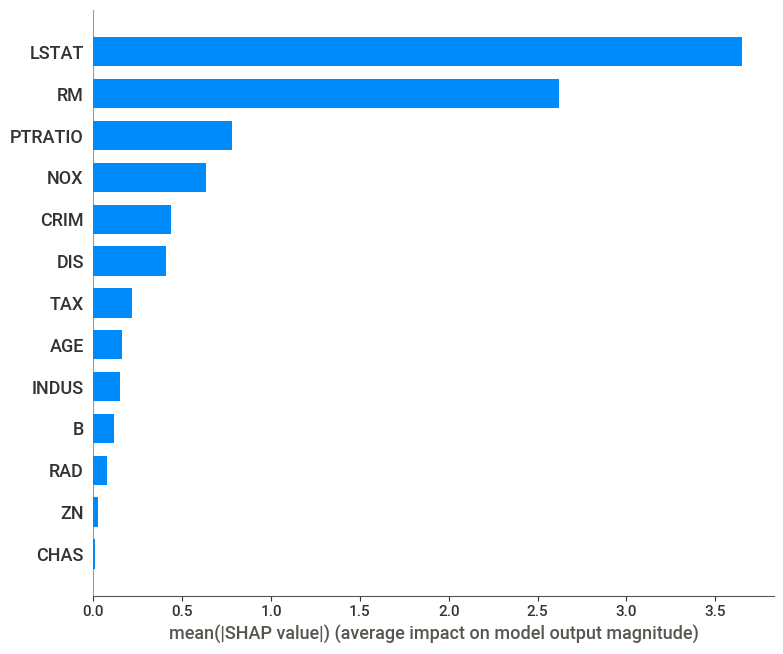

In [45]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

#Impacto de direccionalidad
Trazar gráficos de puntos para visualizar el impacto direccional de las características.

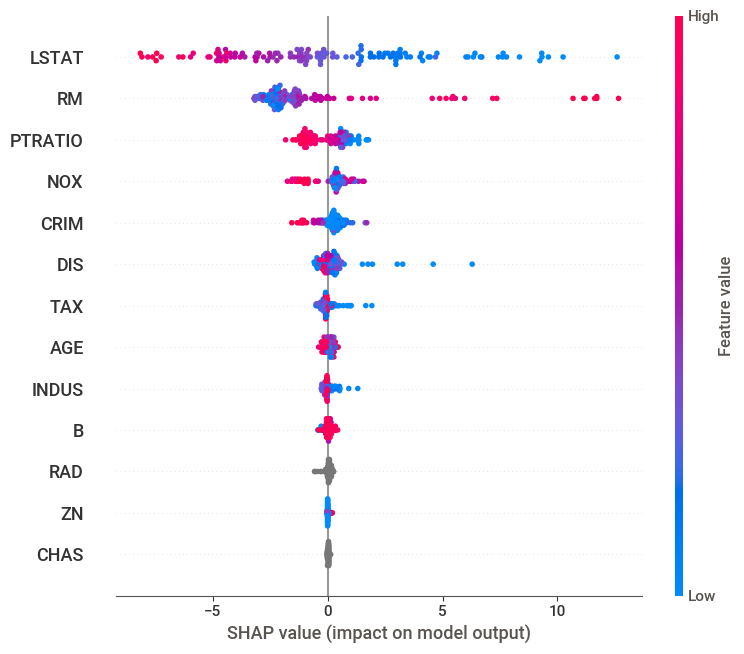

In [46]:
shap.summary_plot(shap_values, X_test, feature_names=datos.columns)


En este gráfico, el eje $x$ representa el valor SHAP y el eje y tiene todas las características. Cada punto del gráfico es un valor SHAP para una predicción y característica. El color rojo significa un valor más alto de una característica. Azul significa valor más bajo de una característica. Podemos tener una idea general del impacto de la direccionalidad de las características en función de la distribución de los puntos rojos y azules.

La interpretación de un gráfico resumido de Shap implica considerar la dirección y la magnitud de los valores de Shapley. Las características con valores positivos de Shapley contribuyen positivamente a la predicción, mientras que aquellas con valores negativos tienen un impacto negativo. La longitud de las barras o la distancia desde la línea central indica la magnitud del efecto. Las características con barras más largas tienen una mayor influencia en las predicciones del modelo.

In [47]:
shap_values

.values =
array([[-2.81524610e-01, -8.62204309e-04, -1.61952785e-02, ...,
        -3.15862319e-01, -2.97603319e-02,  4.04595743e-01],
       [ 2.38789374e-01, -2.98392675e-02, -6.29222561e-03, ...,
         5.36884650e-01, -2.22462776e-02,  3.05237931e+00],
       [-2.39283687e-02,  3.82580043e-02,  1.53088670e-02, ...,
         1.35802344e+00,  1.64595889e-01,  9.23543359e+00],
       ...,
       [ 2.05733971e-01,  4.98232106e-04, -2.13856913e-01, ...,
        -1.20151399e+00,  1.97175849e-01, -4.54381749e+00],
       [ 5.21601608e-01, -1.52867471e-02, -7.64278987e-02, ...,
         3.33773455e-01,  1.06513992e-01, -2.37760263e+00],
       [ 3.07565071e-01, -8.25009303e-03, -4.87718434e-02, ...,
         5.65992114e-01,  8.63667944e-02, -1.71310006e-01]])

.base_values =
array([22.59516623, 22.59516623, 22.59516623, 22.59516623, 22.59516623,
       22.59516623, 22.59516623, 22.59516623, 22.59516623, 22.59516623,
       22.59516623, 22.59516623, 22.59516623, 22.59516623, 22.59516623,
 

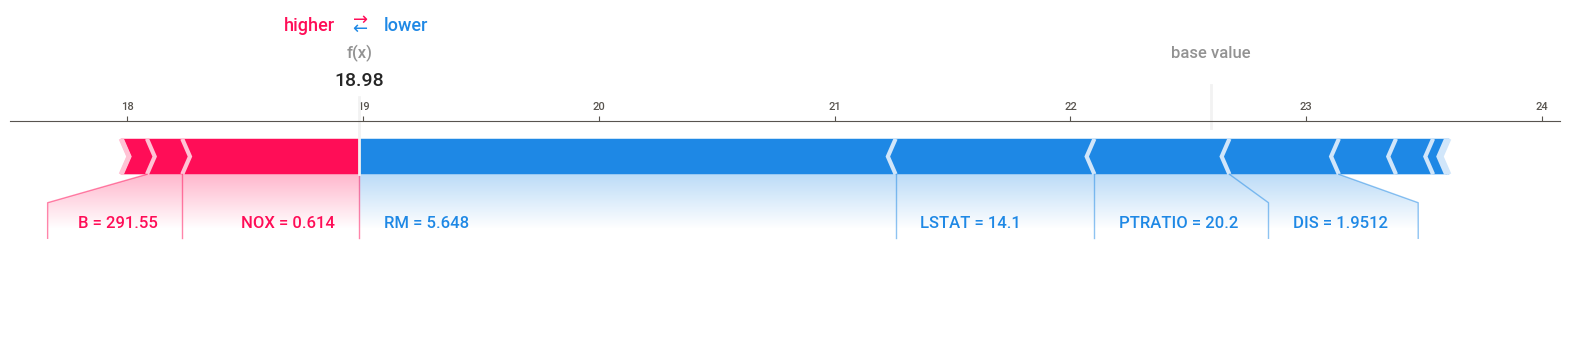

In [48]:
shap.force_plot(
    explainer.expected_value,
    shap_values.values[3, :],
    X_test.iloc[3, :],
    matplotlib=True
)

In [52]:
#!pip install pycaret

  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [50]:
#datos.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [54]:
#from pycaret.regression import setup, compare_models, create_model, tune_model,   plot_model, save_model,evaluate_model

#setup1 = setup(data = datos,  target = 'MEDV',  remove_outliers = True)

ImportError: ignored

In [ ]:
#best_model = compare_models()

In [ ]:
#evaluate_model(best_model)

In [ ]:
#!pip install scikit-optimize

In [ ]:
#rf_model = create_model('rf')
#tuned_rf = tune_model(
#    rf_model,
#    optimize = 'MAE',
    #search_library = 'scikit-optimize',
#     n_iter = 50
#    )